## I. Work space and data preparation

In [197]:
import blpapi
import pandas as pd
import numpy as np
import datetime as dt
from datetime import timedelta
import matplotlib.pyplot as plt
# for RATS regression
import statsmodels.api as sm
from scipy import stats


In [198]:
index_US= ["RIY Index", "USGG10YR Index"]
index_EU= ["SXXP Index", "GDBR10 Index"]
index_UK = ["UKX Index", "GUKG10 Index"]

In [199]:
country = input("Please enter your desired country (US/UK/EU): ")  #  parameter selected by user
country = country.upper()

In [200]:

# get historical price for stocks, rm and rf at the same time
if country =='US':
    rmrf_tickers = index_US
elif country =='EU':
    rmrf_tickers = index_EU
else:
    rmrf_tickers = index_UK

print(rmrf_tickers)

excel_name = str('RATS_') + (rmrf_tickers[0]).split(" ")[0] + str('.xlsx')


['UKX Index', 'GUKG10 Index']


In [201]:
# get the data from the excel file based on the country
df=pd.read_excel(excel_name)
df_data=df[['ID', 'ANNOUNCED_DATE']]
df_data.head()


,ID,ANNOUNCED_DATE
0,FCIT LN Equity,2017-04-25
1,SSE LN Equity,2017-03-31
2,SSE LN Equity,2017-07-05
3,SSE LN Equity,2019-02-01
4,SSE LN Equity,2019-02-01


## II. Bloomberg names set up

In [202]:
DATE = blpapi.Name("date")
ERROR_INFO = blpapi.Name("errorInfo")
EVENT_TIME = blpapi.Name("EVENT_TIME")
FIELD_DATA = blpapi.Name("fieldData")
FIELD_EXCEPTIONS = blpapi.Name("fieldExceptions")
FIELD_ID = blpapi.Name("fieldId")
SECURITY = blpapi.Name("security")
SECURITY_DATA = blpapi.Name("securityData")

## III. BLP class

In [203]:
class BLP():
    
    def __init__(self):               

        # Create Session object
        self.session = blpapi.Session()
        
        # Exit if can't start the Session
        if not self.session.start():
            print("Failed to start session.")
            return
        
        # Open & Get RefData Service or exit if impossible
        if not self.session.openService("//blp/refdata"):
            print("Failed to open //blp/refdata")
            return
        
        self.session.openService('//BLP/refdata')
        self.refDataSvc = self.session.getService('//BLP/refdata')

        print('Session open')
    
    
    def bdh(self, strSecurity, strFields, startdate, enddate, per='DAILY', perAdj = 'CALENDAR', days = 'NON_TRADING_WEEKDAYS', fill = 'PREVIOUS_VALUE', curr = "EUR"):
        
        # Create request
        request = self.refDataSvc.createRequest('HistoricalDataRequest')
        
        # Put field and securities in list is single value is passed
        if type(strFields) == str:
            strFields = [strFields]
            
        if type(strSecurity) == str:
            strSecurity = [strSecurity]
    
        # Append list of securities
        for strF in strFields:
            request.append('fields', strF)
    
        for strS in strSecurity:
            request.append('securities', strS)
    
        # per='DAILY', perAdj = 'CALENDAR', days = 'NON_TRADING_WEEKDAYS', fill = 'PREVIOUS_VALUE', curr = None
        # Set other parameters
        request.set('startDate', startdate.strftime('%Y%m%d'))
        request.set('endDate', enddate.strftime('%Y%m%d'))
        request.set('periodicitySelection', per)
        request.set('nonTradingDayFillMethod',fill)
        request.set('nonTradingDayFillOption',days)
        request.set('currency',curr)
        #perAdj: periodicityAdjustment: ACTUAL, CALENDAR, FISCAL
        request.set('periodicityAdjustment',perAdj)
        
        #-----------------------------------------------------------------------
        # Send request
        #-----------------------------------------------------------------------
        
        requestID = self.session.sendRequest(request)
        print("Sending request")
        
        #-----------------------------------------------------------------------
        # Receive request
        #-----------------------------------------------------------------------
        
        dict_Security_Fields={}
        list_msg=[]
        
        #creat as many empty dictionnaires as fields
        for field in strFields:
            globals()['dict_'+field]={}
        
        #traitement du résultat
        while True:
            event = self.session.nextEvent()
            
            # Ignores anything that's not partial or final
            if (event.eventType() !=blpapi.event.Event.RESPONSE) & (event.eventType() !=blpapi.event.Event.PARTIAL_RESPONSE):
                #continue == on revient à "WHILE"
                continue
            
            # Extract the response message
            for msg in blpapi.event.MessageIterator(event):
                list_msg.append(msg)
                
            # Break loop if response is final
            if event.eventType() == blpapi.event.Event.RESPONSE:
                break        
        
        #-----------------------------------------------------------------------
        # Exploit data 
        #-----------------------------------------------------------------------
                
        for msg in list_msg:
            ticker = str(msg.getElement(SECURITY_DATA).getElement(SECURITY).getValue())

            for field in strFields:
                globals()['dict_' + field][ticker] = {}
                
            for field_data in msg.getElement(SECURITY_DATA).getElement(FIELD_DATA):
                dat=field_data.getElement(DATE).getValue()
                for i in range(1,(field_data.numElements())):
                    field_name = str(field_data.getElement(i).name())
                    try:
                        globals()['dict_'+field_name][ticker][dat]=field_data.getElement(i).getValueAsFloat()
                    except:
                        globals()['dict_'+field_name][ticker][dat]=field_data.getElement(i).getValueAsString()
                    
        for field in strFields:
            dict_Security_Fields[field]=pd.DataFrame.from_dict(globals()['dict_'+field],orient = 'columns')
            
        return dict_Security_Fields
    
    #-----------------------------------------------------------------------------------------------------

    def closeSession(self):
        print("Session closed")
        self.session.stop()

## IV. Run Bloomberg 

In [204]:
#Historical price period 
start_date = pd.to_datetime('2016-01-01')
end_date = pd.to_datetime('2020-01-01')

In [205]:
# Based on the announcement date, get daily last price from -6 to +48 months.
blp = BLP()
strFields = ["PX_LAST"]
tickers = df_data["ID"].tolist()

tickers = rmrf_tickers + tickers # to make sure that the first two columns are rm and rf
startDate = start_date - timedelta(days=30*7)  
endDate = end_date + timedelta(days=30*48)
dict_output = blp.bdh(strSecurity=tickers, strFields = strFields, startdate = startDate, enddate = endDate)

Session open
Sending request


In [206]:
px_last_df=dict_output["PX_LAST"]
px_last_df.index = pd.to_datetime(px_last_df.index)
px_last_df.tail()


,RMV LN Equity,SN/ LN Equity,GLEN LN Equity,KGF LN Equity,FRAS LN Equity,PSON LN Equity,REL LN Equity,HSBA LN Equity,LSEG LN Equity,VOD LN Equity,...,AAL LN Equity,PSH LN Equity,FLTR LN Equity,IAG LN Equity,BP/ LN Equity,UKX Index,GUKG10 Index,FCIT LN Equity,SSE LN Equity,AHT LN Equity
2023-12-05,6.39087,11.96828,5.11643,2.60490,10.57364,10.96110,35.85234,7.04209,104.33590,0.83515,...,25.15032,36.71597,146.93389,1.81829,5.50739,8741.15408,4.025,10.39858,21.85335,55.26068
2023-12-06,6.57871,12.00107,5.20999,2.62892,10.59502,10.91474,36.07907,7.17264,104.10655,0.84235,...,25.65908,37.05922,151.69078,1.88913,5.43695,8769.33739,3.943,10.47833,21.82014,56.55732
2023-12-07,6.66861,12.00979,5.28582,2.65369,10.65789,10.98771,36.01190,7.13712,104.67925,0.81347,...,25.92507,37.76005,150.34095,1.84255,5.36391,8756.74248,3.968,10.47725,21.79361,56.93144
2023-12-08,6.77223,12.22990,5.33520,2.70726,10.71939,11.20229,36.24063,7.22246,106.14411,0.80774,...,21.02586,38.02525,153.44239,1.84761,5.46176,8811.67540,4.041,10.60275,21.95783,58.69419
2023-12-11,6.78876,12.24452,5.12776,2.70920,10.76794,11.25235,36.38337,7.19497,106.80394,0.80015,...,20.88221,38.05255,154.31126,1.82092,5.45400,8806.81920,4.078,10.66872,21.59424,59.43668


In [207]:
# to decide if the date is a weekend or holiday
def findDate(date, df):
    for i in range(5):
        current_date=date+pd.DateOffset(days=i)
        if current_date in df.index:
            break
        
    return current_date
            

In [208]:
# create three DataFrame for different time windows
col_name=['T-1','T0','T+1','rm-1','rm0','rm1']
df_st_3d = pd.DataFrame(np.zeros((df_data.shape[0],6)),columns=col_name) 
df_st_5d = pd.DataFrame(np.zeros((df_data.shape[0],6)),columns=col_name) 
df_st_7d =pd.DataFrame(np.zeros((df_data.shape[0],6)),columns=col_name) 

# daily market return, and stock return == used in the calculation of short-term return
rm=px_last_df[rmrf_tickers[0]].pct_change() # Market returns
ri=px_last_df.pct_change() # Stock return

# convert risk-free rate into percentage
rf=px_last_df[rmrf_tickers[1]]/100


# calculate elements before regression
X=pd.DataFrame(np.zeros((55,df_data.shape[0]))) #LT rm - rf
Y=pd.DataFrame(np.zeros((55,df_data.shape[0]))) # LT ri - rf

for i in range(0,df_data["ID"].shape[0]): 
    ticket=df_data.iloc[i,0]  # stock name
    date_ini=df_data.iloc[i,1] # initial date
    date_use=findDate(date_ini,px_last_df) # find the nearest available price if current date is a holiday or weekdend
    col_use=ri.columns.get_loc(ticket)
    row_use=ri.index.get_loc(date_use)  #locate the start price for this stock 
   
    # ST +/-1 day price 
    df_st_3d.iloc[i,0:3] = px_last_df.iloc[row_use -1: row_use + 2,col_use].values
    df_st_3d.iloc[i,3:6] = rm.iloc[row_use-1:row_use+2]

    # ST +/-2 days price
    df_st_5d.iloc[i, 0:3] = px_last_df.iloc[[row_use-2, row_use, row_use+2], col_use].values
    df_st_5d.iloc[i, 3:6] = rm.iloc[[row_use-2, row_use, row_use+2]]

    # ST +/-3 days price
    df_st_7d.iloc[i, 0:3] = px_last_df.iloc[[row_use-3, row_use, row_use+3], col_use].values
    df_st_7d.iloc[i, 3:6] = rm.iloc[[row_use-3, row_use, row_use+3]]

    # LT -6/+48 month price  
    for j in range(-6, 49):
        
        # define the specific period for price needed.
        date_lt_end=date_use + timedelta(days=30*j)  
        date_lt_end_use=findDate(date_lt_end,px_last_df)
        date_lt_bgn = date_lt_end_use - timedelta(days=30)
        date_lt_bgn_use = findDate(date_lt_bgn,px_last_df)
        
        # locate stock data
        col = px_last_df.columns.get_loc(ticket)
        row_bgn = px_last_df.index.get_loc(date_lt_bgn_use)
        row_end = px_last_df.index.get_loc(date_lt_end_use)

        # calculate Rm, Rf, and Ri
        monthly_Rm = px_last_df.loc[px_last_df.index[row_end], rmrf_tickers[0]] /  px_last_df.loc[px_last_df.index[row_bgn], rmrf_tickers[0]] -1
        
        monthly_Rf = rf.iloc[row_end] / 12
        monthly_Ri = px_last_df.iloc[row_end,col]/ px_last_df.iloc[row_bgn,col] - 1                                                          
        
        X.iloc[j,i] = monthly_Rm - monthly_Rf
        Y.iloc[j,i] = monthly_Ri - monthly_Rf
        

# V. ST Return

In [209]:

col_name=['ID','RETURN 3d', 'RETURN 5d', 'RETURN 7d']
st_result=pd.DataFrame(np.zeros((df_data.shape[0],4)), columns=col_name)
st_result['ID']=df_data['ID']
#st_return=(df_st['T0']/df_st['T-1']) - df_st['rm0']/df_st['rm-1'] + (df_st['T+1']/df_st["T0"]) - df_st['rm1']/df_st['rm0']
st_return_3d=(df_st_3d['T0']/df_st_3d['T-1'] - 1) - df_st_3d['rm0'] + (df_st_3d['T+1']/df_st_3d["T0"] - 1) - df_st_3d['rm1']
st_return_5d=(df_st_5d['T0']/df_st_5d['T-1'] - 1) - df_st_5d['rm0'] + (df_st_5d['T+1']/df_st_5d["T0"] - 1) - df_st_5d['rm1']
st_return_7d=(df_st_7d['T0']/df_st_7d['T-1'] - 1) - df_st_7d['rm0'] + (df_st_7d['T+1']/df_st_7d["T0"] - 1) - df_st_7d['rm1']


st_result['RETURN 3d']=st_return_3d.to_frame()
st_result['RETURN 5d']=st_return_5d.to_frame()
st_result['RETURN 7d']=st_return_7d.to_frame()

In [210]:
print(f'average {country} short term return 3d: ', np.mean(st_return_3d))
print(f'average {country} short term return 5d: ', np.mean(st_return_5d))
print(f'average {country} short term return 7d: ', np.mean(st_return_7d))

average UK short term return 3d:  0.004327283743050641
average UK short term return 5d:  0.006560551344240149
average UK short term return 7d:  0.008321685932252819


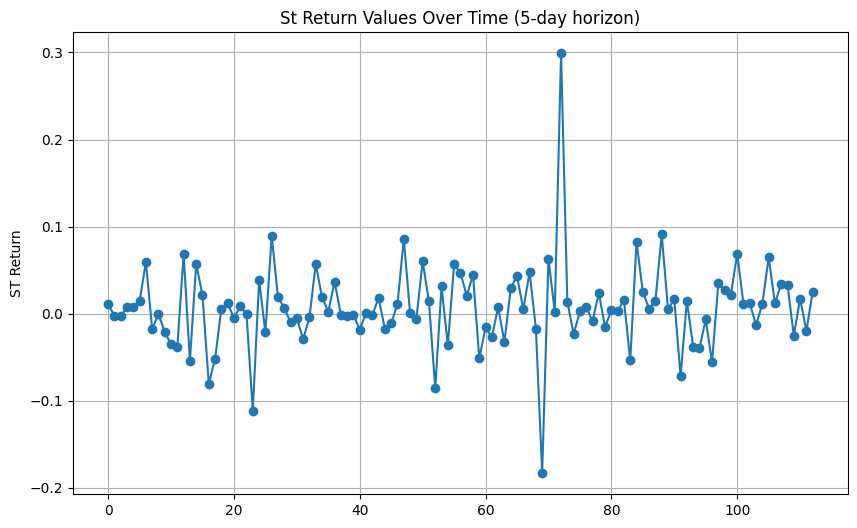

In [211]:
plt.figure(figsize=(10, 6))  
plt.plot(st_return_5d, marker='o')  
plt.title('St Return Values Over Time (5-day horizon)')  
plt.ylabel('ST Return')
plt.grid(True)  
plt.show() 

# VI. LT RATS

In [212]:
#delete stocks that have empty return numbers 
index=[]
for i in range(0,Y.shape[1]):
    count=Y.iloc[:,[i]].isna().sum().sum()
    if count > 0:
        index.append(i)
Y.drop(Y.columns[index],axis=1,inplace=True)
X.drop(X.columns[index],axis=1,inplace=True)


In [213]:
# RATS regression
alpha=[]
tstat=[]
se=[]
for i in range(Y.shape[0]):  
    x_reg=X.iloc[i,:].T
    y_reg=Y.iloc[i,:].T
    x_add_constant = sm.add_constant(x_reg)
    regression = sm.OLS(y_reg,  x_add_constant)
    results = regression.fit()

    alpha.append(results.params.iloc[0])
    tstat.append(results.tvalues.iloc[0])
    se.append(results.bse.iloc[0])


CAR=np.cumsum(alpha)
se_2=[element**2 for element in se]
alpha_2=[element**2 for element in CAR]
SE = np.sqrt(np.cumsum(se_2))

tstat = CAR/SE
p_value = stats.t.sf(abs(tstat), len(tstat)-1)


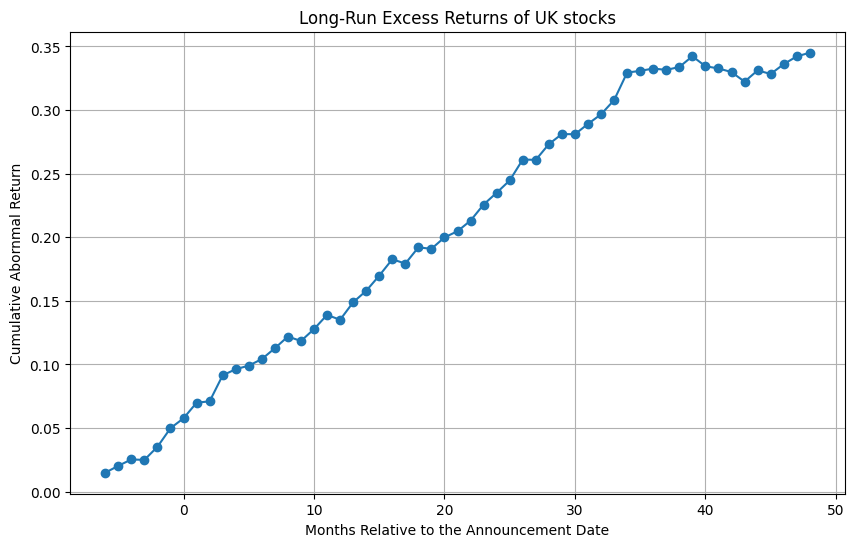

In [214]:
#Cumulated Alpha graph
months = list(range(-6, 49))
plt.figure(figsize=(10, 6))  
plt.plot(months, CAR, marker='o')  
plt.title(f'Long-Run Excess Returns of {country} stocks')  

plt.xlabel('Months Relative to the Announcement Date')  
plt.ylabel('Cumulative Abornmal Return')
plt.grid(True)  
plt.show()  

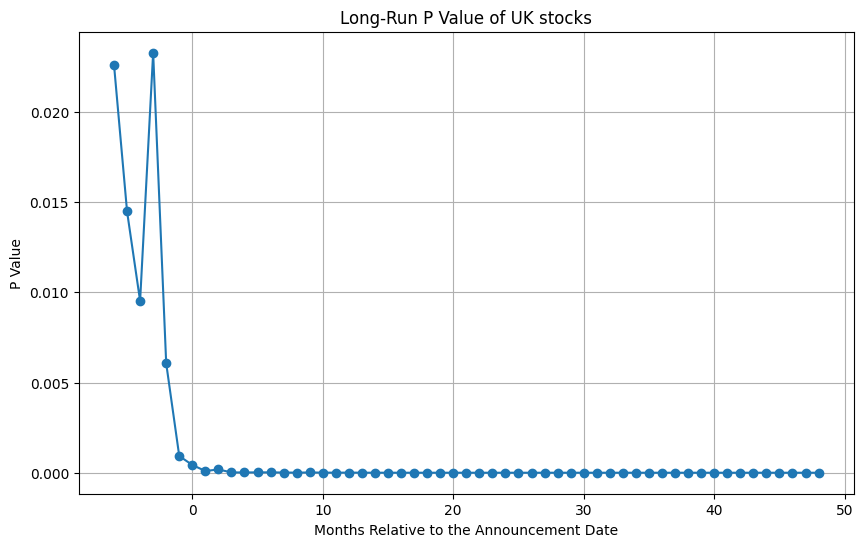

In [215]:
#P Value graph
months = list(range(-6, 49))
plt.figure(figsize=(10, 6))  
plt.plot(months, p_value, marker='o')  
plt.title(f'Long-Run P Value of {country} stocks')  
plt.xlabel('Months Relative to the Announcement Date')  
plt.ylabel('P Value')
plt.grid(True)  
plt.show()  

In [216]:
row_table = [CAR[-37], p_value[-37], CAR[-25], p_value[-25], CAR[-13], p_value[-13], CAR[-1], p_value[-1]]
df_LR_RATS = pd.DataFrame([row_table], index=[country], columns=['alpha_1y', 'pval_1y','alpha_2y', 'pval_2y','alpha_3y', 'pval_3y','alpha_4y', 'pval_4y'])
print(df_LR_RATS)


    alpha_1y   pval_1y  alpha_2y       pval_2y  alpha_3y       pval_3y  \
UK  0.135119  0.000007  0.234971  1.755951e-08  0.332595  8.211613e-10   

    alpha_4y       pval_4y  
UK  0.345024  3.604352e-09  
